##Process a credit card bill, extract the data and send it to a google spreadsheet.

## This notebook needs the files: mock_credit_card_bill.pdf


## How to use it?

1.   Go to this example google spreadsheet https://docs.google.com/spreadsheets/d/1JA1ALNcVTlfkCTMwSr2iTb2ZceTsx-txNfvRYGsAeDg/edit?usp=sharing and make a copy in your account. Note that you need to input the file and the page names later in the code.

2.   Look for, in your credit card bill, words that can be used to distinguish between the categories used in the example spreadsheet. the categories are: grocery, transportation, drugstore, petshop, monthly, one-off;
3.   Run the "SETUP" cell and wait for its completion. check if everything was installed correctly;
4.   Go to the "Set CONFIG here" cell (bellow the setup) and fill the "<>" with your info. (sheets name, credict card bill .pdf file's name, etc);
5.  Still in the "Set CONFIG here" cell, Edit the "CATEGORIES" section lists with the words that better describe the category of your purchases for example: "uber" fits in "transportation";
6.   In this same cell configure the coordinates and the height. Those are used to resize and crop the images of the credict card bill. There are alredy sugested values, but its important to adjust these for an optimal result;
7.   Run the "FUNCTIONS" cell;
8.  The "TESTING CROPPING CONFIG" cell is used to see if the crop confiiigurations are fit to your credit card bill layout. This cell is not mandatory in this notebook;
9.   Run the "PIPELINE" cell and give permission to this notebook to access and edit your google spreadsheet;
10.   Its done! check your info in the google spreadsheet you specified.


## Important to know:
- The "preprocess" configurations are set specifically for credit card bills from a very distinguished purple colored bank, if your bills are from other bank the configurations must be adapted to your case.
- The information in the .txt files is subjective and must be constumized to work as intended.
- All the purchases that are not classified will be put in the "One-off" category. So if you got too much purchases sorted this way maybe is time to update the "CATEGORIES" list's words.
- The page_name variable  (in "CONFIG" cell) refers to the page you want to fill in with the credit card bill data. Its set by default to "pdf_path[9:-4]", in other words, the name of the .pdf file without ".pdf" at the end. Default = "mock_pdf_credit_card_bill"

In [ ]:
# SETUP
!pip install pdf2image
!sudo apt-get update
!sudo apt-get install poppler-utils
!pip install easyocr


import os
import numpy as np
import PIL
import cv2
from pdf2image import convert_from_path, convert_from_bytes
from IPython.display import display, Image
import easyocr
import re
import gspread


reader = easyocr.Reader(['pt','en'])

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [634 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [1,572 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [ ]:
# Set CONFIG here

### <> insert your data bellow ###
sheet_name = "portfolio - credit card extraction" # <>
pdf_path = "/content/mock_credit_card_bill.pdf"   # <>

page_name = pdf_path[9:-4] # <> # used to find the correct page to insert the data.
                                # Use the exact same name as the sheet file's page.
remove_string = "pagamento em"         # <> # string to remove payment info (noise)


# Dimentions config
h_size = 1500                        # <> #  the height of the resulting croped images
crop_config = (300, 230, 1000, 1400) # <> # crop only the purchase information
pages = (0,1)                        # <> # pages with actual purchases listed

txt_paths = ["/content/grocery.txt", "/content/drugstore.txt",
             "/content/transportation.txt", "/content/petshop.txt",
             "/content/monthly.txt"]

img_names="img"     # prefix input for the resulting images
bin_threshold = 220 # threshold for binarization algorithm
cells_tuple = ("B2", "E2", "H2", "K2", "N2", "Q2", "R2") # grocery, transportation, drugstore, petshop, monthly, undefined_values, undefined_items


# CATEGORIES
grocery_related = ["super", "market", "gas"]

transportation_related = ["uber", "trip", "cab", "taxi", "flight"]

drugstore_related = ["drug", "drugstore", "farmacia"]

petshop_related = ["pet", "animal"]

monthly_related = ["prime", "netflix", "globo"]

# this list cannot be modified
categories_listing = [grocery_related, transportation_related, drugstore_related,
                      petshop_related, monthly_related]

In [ ]:
# FUNCTIONS

# transform pdf into png and saves it
def pdf_to_png(pdf_path: str, h_size: int, crop_config: tuple, img_names: str):
  '''
  Function to transform .pdf file into .png. each page turns into an image.
  The dimentions must be specified.
  Returns the img_paths list to serve as the input of the "extract_text" function.

  pdf_path: the path to access the .pdf to process;
  h_size: the height of the generated image;
  crop_config: a tuple with this structure (left, top, right, bottom) all int type;
  img_names: name that initiate the image's name.
  '''
  images = convert_from_bytes(open(pdf_path, 'rb').read(), size=h_size)
  img_paths = []
  for idx,img in enumerate(images):
    img = img.crop(crop_config)
    name = f"{img_names}_{idx}.png"
    img_paths.append(name)
    img.save(name)

  return img_paths

def preprocess_img(img_paths_list: list, bin_threshold: int, pages: tuple):
  for page in pages:
    img_path = img_paths_list[page]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret,img = cv2.threshold(img, bin_threshold, 255, cv2.THRESH_BINARY)
    cv2.imwrite(img_path, img)


def extract_text(img_paths_list: list, reader, pages: tuple):
  '''
  Using the OCR Reader instanced, reads the images and extracts the text from it

  img_paths_list: list containing the path to the images to read;
  reader: OCR reader object;
  pages: Specify the pages of the .pdf file that are going to be processed.
  '''
  img_path_list = [x for x in os.listdir(".") if x.endswith(".png")]
  img_path_list.sort()
  bounds = []
  for p in pages:
    img = img_path_list[p]
    bounds = bounds + reader.readtext(os.path.join(img))

  return bounds


def separate_and_clean_items_values(extracted_text: list, remove_string: str):
  '''
  Get the raw OCR output, separates it into a item's names list and a item's
  values list and cleans these two lists formatting them as the script needs.
  Uses the function "remove_a_line" to remove the "last bill payment" line.

  extracted_text: Raw OCR output with text, bounding boxes and confidence scores
  Commonly called "bounds".
  remove_string: string to find and remove from lists used in "remove_a_line" function.
  '''
  unified_items_list = [x[1].lower() for x in extracted_text]
  unified_items_string = " ".join(unified_items_list)

  sep_items_list = re.split(r"\d+\,\d+" , unified_items_string)
  sep_items_list.pop()
  sep_items_list = [x.strip() for x in sep_items_list]

  sep_items_list = [re.sub('[^A-Za-z0-9-" "/]+', '', x) for x in sep_items_list]

  sep_values_list = re.findall(r"\d+\,\d+" , unified_items_string)
  sep_values_list = [float(x.replace(',', '.')) for x in sep_values_list]

  remove_a_line(rm_init="pagamento em",
                rm_check=sep_items_list,
                rm_from=[sep_items_list, sep_values_list])
  try:
    assert len(sep_items_list) == len(sep_values_list)
  except AssertionError:
    print("Error on separating items and values.")

  checksum_init = len(sep_items_list)

  return sep_items_list, sep_values_list, checksum_init


# Removing an specific string from the lists
# This function removes the string in place (no copies created)
def remove_a_line(rm_init: str, rm_check: list, rm_from: list):
  '''
  caution, this function alters this lists IN PLACE

  rm_init: string to remove starts with what;
  rm_check: from which list this function will look for the string to remove;
  rm_from: which lists are going to be modified
  '''

  for idx, item in enumerate(rm_check):
    if item.startswith(rm_init):
      for l in rm_from:
        l.pop(idx)


def separate_and_verify(categories_listing: list, items_list: list, values_list:list):
  '''
  uses the function "separate_specific_lists" to get specific category items
  and add them to specific lists called Result Lists, these lists contain only
  specified items in this categories: grocery, drugstore, transportation, monthly,
  undefined.

  txt_paths: the path to the .txt files containing names that categorize items;
  items_list: list with all the item's names from the credit card bill;
  values_list: list with all the item's values from the credit card bill;
  '''

  grocery_items, grocery_values, items_list, values_list = separate_specific_lists(items_list=items_list, values_list=values_list, category=categories_listing[0])
  transportation_items, transportation_values, items_list, values_list = separate_specific_lists(items_list=items_list, values_list=values_list, category=categories_listing[1])
  drugstore_items, drugstore_values, items_list, values_list = separate_specific_lists(items_list=items_list, values_list=values_list, category=categories_listing[2])
  petshop_items, petshop_values, items_list, values_list = separate_specific_lists(items_list=items_list, values_list=values_list, category=categories_listing[3])
  monthly_items, monthly_values, items_list, values_list = separate_specific_lists(items_list=items_list, values_list=values_list, category=categories_listing[4])
  # remove the rest of the items from items_list and values-List
  undefined_items, undefined_values = [], []
  undefined_items, undefined_valius, items_list, values_list = add_leftover_to_undefined(items_list=items_list, values_list=values_list, to_list_items=undefined_items, to_list_values=undefined_values)

  checksum_items = len(grocery_items) + len(drugstore_items) + len(transportation_items) + len(petshop_items) + len(monthly_items) + len(undefined_items)
  checksum_values = len(grocery_values) + len(drugstore_values) + len(transportation_values)+ len(petshop_items) + len(monthly_values) + len(undefined_values)

  try:
    assert checksum_items == checksum_values
  except:
    print("Error on the separation of items and values")



  return (grocery_items, grocery_values, drugstore_items,drugstore_values,
          transportation_items, transportation_values, petshop_items, petshop_values,
          monthly_items, monthly_values, undefined_items, undefined_values,
          checksum_items)


# "inside separate_and_verify"
def separate_specific_lists(items_list: list, values_list:list, category: list):
  '''
  Uses words from the .txt files to categorize items from the items list.
  The "items_list" and "values_list" are then reduced to speed up the process
  and avoid geting the same information more than once.

  txt_path: the path to the .txt file containing names from only 1 category;
  items_list: list with all the item's names from the credit card bill;
  values_list: list with all the item's values from the credit card bill;
  '''
  text = category

  return_list_items, return_list_values = [], []
  for word in text:
    for idx,item in enumerate(items_list):
      if word in item:
        return_list_items.append(item)
        return_list_values.append(values_list[idx])

        items_list[idx] = ""
        values_list[idx] = ""

    items_list = [item for item in items_list if item]
    values_list = [value for value in values_list if value]

  return return_list_items, return_list_values, items_list, values_list


# "inside separate_and_verify"
def add_leftover_to_undefined(items_list: list, values_list:list,
                              to_list_items: list, to_list_values: list):
  '''
  The last step of the categorization. Here items that dont belong to the other
  categories are thrown into the undefined category.
  Used inside "separate_and_verify" function.

  items_list: list with all the item's names from the credit card bill;
  values_list: list with all the item's values from the credit card bill;
  to_list_items: items that will be sent to the undefined_items list;
  to_list_values: values that will be sent to the undefined_values list.
  '''

  for idx,item in enumerate(items_list):
    to_list_items.append(item)
    to_list_values.append(values_list[idx])

  return to_list_items, to_list_values, items_list, values_list


# connect and edit the spreadsheet using colab

def connect_sheet(sheet_name: str, page_name: str):
  '''
  Creating a object that connects to the specified spreadsheet.
  '''
  worksheet = gc.open(sheet_name)
  worksheet = worksheet.worksheet(page_name)

  return worksheet

def add_list_to_sheet(cells_init: str,
                      list_to_add: list,
                      worksheet:gspread.models.Worksheet):
  '''
  Add a specific list to the spreadsheet. used in "checkout_to_sheet" function.

  cells_init: letter + number of the first cell in the column/row;
  list_to_add: the list with the values you would like to add;
  worksheet: the object relative to the specific spreadsheet.
  '''
  cells_end = int(cells_init[1:]) + len(list_to_add)
  cells_range = worksheet.range(f"{cells_init}:{cells_init[0]}{cells_end}")
  for cell, item in zip(cells_range, list_to_add):
    cell.value = item
  worksheet.update_cells(cells_range)
  return True


def checkout_to_sheet(values_lists: list,
                      cells_tuple: tuple,
                      worksheet: gspread.models.Worksheet):
  '''
  Function that uses "add_list_to_sheet" function to update the specific
  spreadsheet with all the 5 Result Lists.

  values_lists: list containing the lists with values (_value lists);
  init_cells_lis: The initial cell coordinates for each category;
  worksheet: the object connecting colab to the spreadsheet.
  '''
  for category, cell_init in zip(values_lists, cells_tuple):
    add_list_to_sheet(cells_init=cell_init,
                      list_to_add=category,
                      worksheet=worksheet)
  return True


def checksum_calc(checksum_init: int, checksum_end: int):
  if checksum_init == checksum_end:
    return True
  else:
    return False

def verify_pages(pages: tuple):
  '''
  Verify if there are more then one page to process.
  returns True for more than one page;
  returns False if only one page.

  pages: tuple containing the page numbers.
  '''
  if len(pages) > 1:
    return True
  else:
    return False


# Usage before separating the categories
def check_installments(items_list: list):
  '''
  Creates a new list with True for installemts items and False for unique
  payment items

  items_list: The list with all the items before separation by category.
  '''
  # this regex pattern matches "integer/integer". This categorizes installemnts.
  installments_list = [True if re.findall(r"\d+/\d+", item) else False for item in items_list]

  return installments_list


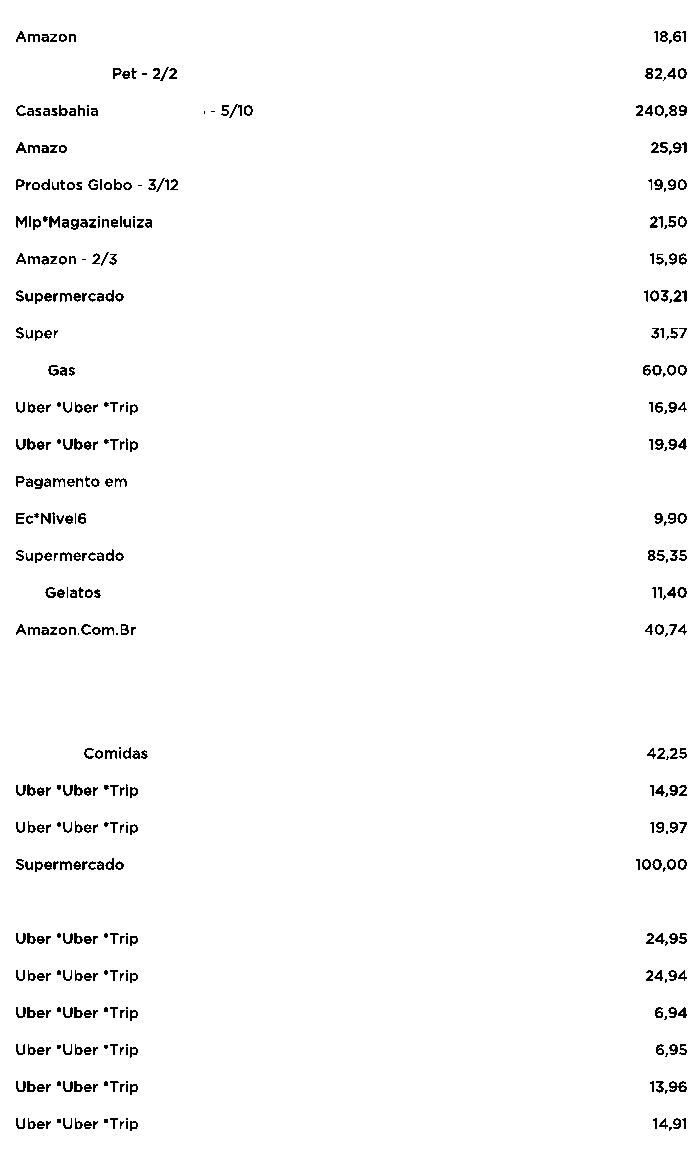

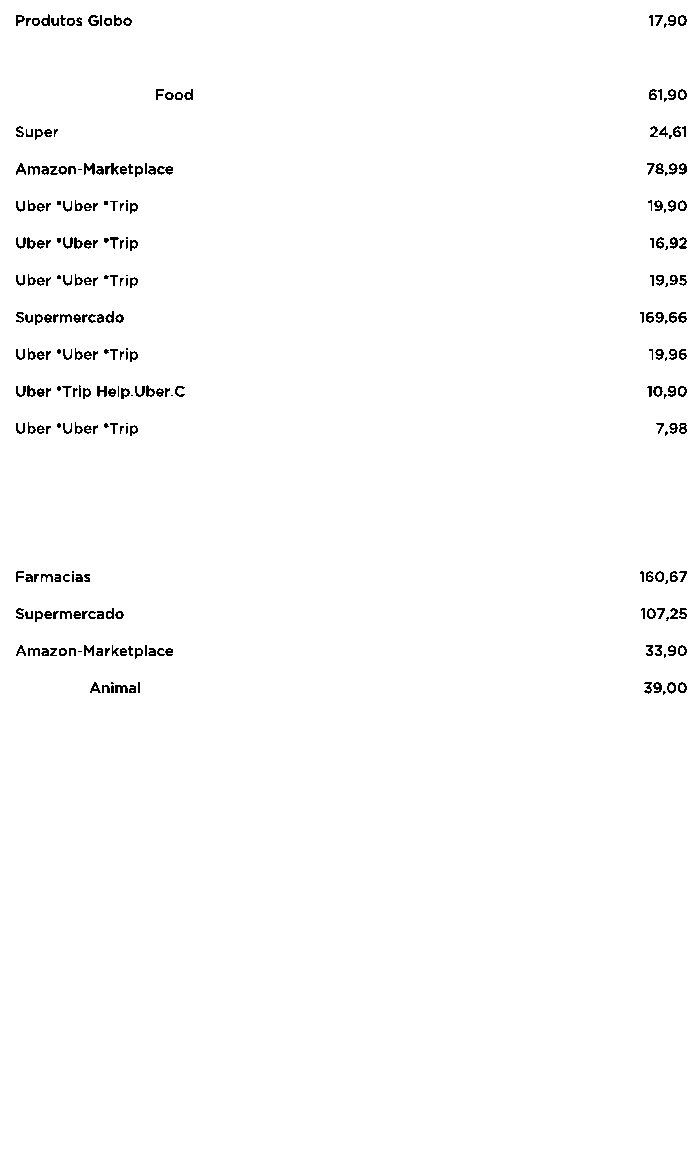

In [ ]:
# "TESTING CROP CONFIG"
# there must be only text lines from the purchases, no adittional info
# even symbols can be interpreted as characters by the OCR algorithm
from google.colab.patches import cv2_imshow

def test_cropping(credit_cart_bill_path: str):
  img_paths_list = pdf_to_png(pdf_path=pdf_path, h_size=h_size, crop_config=crop_config, img_names=img_names)

  img = preprocess_img(img_paths_list=img_paths_list,
                       bin_threshold=bin_threshold,
                       pages=pages)
  return img_paths_list

crop_result_imgs = test_cropping(credit_cart_bill_path="/content/mock_credit_card_bill.pdf")

for img in crop_result_imgs:
  img = cv2.imread("/content/" + img)
  cv2_imshow(img)

In [ ]:
# PIPELINE

# Integration with google spreadsheets
# 1. Authorizing google colab
from google.colab import auth
auth.authenticate_user()
# 2. credentials for google sheets
from google.auth import default
creds, _ = default()
# 3. authotizing the connection
gc = gspread.authorize(creds)


worksheet = connect_sheet(sheet_name=sheet_name, page_name=page_name)

img_paths_list = pdf_to_png(pdf_path=pdf_path, h_size=h_size, crop_config=crop_config, img_names=img_names)

img = preprocess_img(img_paths_list=img_paths_list,
                     bin_threshold=bin_threshold,
                     pages=pages)

extracted_text = extract_text(img_paths_list=img_paths_list, reader=reader, pages=pages)

sep_items_list, sep_values_list, checksum_init = separate_and_clean_items_values(extracted_text=extracted_text, remove_string=remove_string)

installments_list = check_installments(items_list=sep_items_list)

(grocery_items, grocery_values, drugstore_items,drugstore_values,
transportation_items, transportation_values, petshop_items, petshop_values,
monthly_items, monthly_values, undefined_items, undefined_values, checksum_end) = separate_and_verify(categories_listing=categories_listing, items_list=sep_items_list, values_list=sep_values_list)

try:
  condition = checksum_calc(checksum_init=checksum_init, checksum_end=checksum_end)
  assert condition == True
except:
  print("wrong checksum!")


# Mannualy created list
values_lists = [grocery_values, transportation_values, drugstore_values,
                petshop_values, monthly_values, undefined_values,
                undefined_items]

# Fill the spreadsheet with the informations extracted
checkout_to_sheet(values_lists=values_lists,
                  cells_tuple=cells_tuple,
                  worksheet=worksheet)

True